In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device
from src.models.Sirenlayer import SirenNet
from src.optimize import optimize_nise_vf
from src.results.display import display_result,display_loss
device

device(type='cuda')

(200, 200)


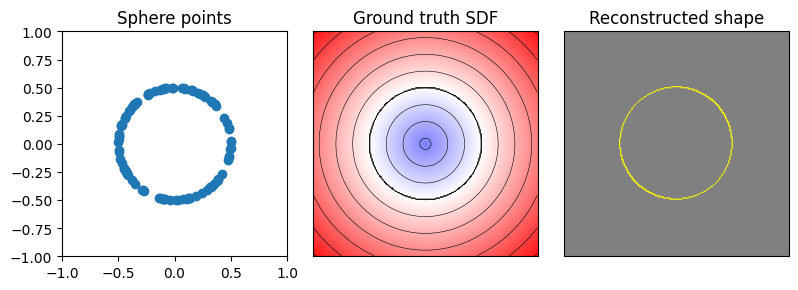

In [3]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 3, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
print(sdf_numpy.shape)
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


plt.tight_layout()
plt.show()

In [5]:

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
# optimize_nise_vf(
#     net=true_net,
#     pc0=pc_t0,
#     # nc0=nc0,
#     hints0=pts_hintst0,
#     gtsdf0=gt_sdf_hints0,
#     # vf=vf,
#     # lpc=lpc,
#     # leik=leik,
#     # lh=lh,
#     # llse=llse,
#     # lemd=lemd,
#     # lgc=lgc,
#     lambda_pc=1,# 
#     lambda_eik=0.001, # eikonal,
#     lambda_hint=0, # used but need ground truth,
#     lambda_lse=2, # not used,
#     lambda_gc=0.001, #geometric consistency,
#     lambda_emd=1, # lambda EMD,
#     batch_size=2000,
#     nepochs=nepochs,
#     plot_loss=True,
#     follow_paper=False,
#     list_loss=list_loss,
# )

# torch.save(true_net, "net_vf_{}_{}.net".format(npl, depth))

In [6]:
import commentjson as json
import tinycudann as tcnn
import torch

In [7]:
import json
import tinycudann as tcnn

json_config = {
	"loss": {
		"otype": "MAPE"
	},
	"optimizer": {
		"otype": "Ema",
		"decay": 0.95,
		"nested": {
			"otype": "ExponentialDecay",
			"decay_start": 10000,
			"decay_interval": 5000,
			"decay_base": 0.33,
			"nested": {
				"otype": "Adam",
				"learning_rate": 1e-4,
				"beta1": 0.9,
				"beta2": 0.99,
				"epsilon": 1e-15,
				"l2_reg": 1e-6
			}
		}
	},
	"encoding": {
		"otype": "HashGrid",
		"n_levels": 16,
		"n_features_per_level": 2,
		"log2_hashmap_size": 19,
		"base_resolution": 16
	},
	"network": {
		"otype": "FullyFusedMLP",
		"activation": "ReLU",
		"output_activation": "None",
		"n_neurons": 64,
		"n_hidden_layers": 2
	}
}

# Correct JSON handling
config = json.loads(json.dumps(json_config))

# Option 1: efficient Encoding+Network combo.
model = tcnn.NetworkWithInputEncoding(
    2, 3,
    config["encoding"], config["network"]
)

input=torch.rand((2000,2))
# convert it to cuda tensor
input=input.cuda()

In [9]:
{
	"loss": {
		"otype": "MAPE"
	},
	"optimizer": {
		"otype": "Ema",
		"decay": 0.95,
		"nested": {
			"otype": "ExponentialDecay",
			"decay_start": 10000,
			"decay_interval": 5000,
			"decay_base": 0.33,
			"nested": {
				"otype": "Adam",
				"learning_rate": 1e-4,
				"beta1": 0.9,
				"beta2": 0.99,
				"epsilon": 1e-15,
				"l2_reg": 1e-6
			}
		}
	},
	"encoding": {
		"otype": "HashGrid",
		"n_levels": 16,
		"n_features_per_level": 8,
		"log2_hashmap_size": 19,
		"base_resolution": 16
	},
	"network": {
		"otype": "FullyFusedMLP",
		"activation": "ReLU",
		"output_activation": "None",
		"n_neurons": 64,
		"n_hidden_layers": 2
	}
}

{'loss': {'otype': 'MAPE'},
 'optimizer': {'otype': 'Ema',
  'decay': 0.95,
  'nested': {'otype': 'ExponentialDecay',
   'decay_start': 10000,
   'decay_interval': 5000,
   'decay_base': 0.33,
   'nested': {'otype': 'Adam',
    'learning_rate': 0.0001,
    'beta1': 0.9,
    'beta2': 0.99,
    'epsilon': 1e-15,
    'l2_reg': 1e-06}}},
 'encoding': {'otype': 'HashGrid',
  'n_levels': 16,
  'n_features_per_level': 8,
  'log2_hashmap_size': 19,
  'base_resolution': 16},
 'network': {'otype': 'FullyFusedMLP',
  'activation': 'ReLU',
  'output_activation': 'None',
  'n_neurons': 64,
  'n_hidden_layers': 2}}

In [4]:
from torch import autograd

class SDF(nn.Module):
    def __init__(self, hash=True, n_levels=12, log2_hashmap_size=15, base_resolution=16, smoothstep=False) -> None:
        super().__init__()
        self.encoder = tcnn.Encoding(2, config["encoding"])
        self.decoder = nn.Sequential(
            nn.Linear(self.encoder.n_output_dims, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

        self.init_weights()

    def forward(self, x):
        encoded = self.encoder(x).to(dtype=torch.float)
        sdf = self.decoder(encoded)
        return sdf

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                ## Initialization of first layer type
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
                ## Other initialization
            self.fc1.weight.uniform_(-size, size)

    def forward_with_nablas(self, x):
        with torch.enable_grad():
            x = x.requires_grad_(True)
            sdf = self.forward(x)
            nablas = autograd.grad(
                sdf,
                x,
                torch.ones_like(sdf, device=x.device),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]
        return sdf, nablas


In [5]:
class NGP_SDF(nn.Module):
    config={
	"loss": {
		"otype": "MAPE"
	},
	"optimizer": {
		"otype": "Ema",
		"decay": 0.95,
		"nested": {
			"otype": "ExponentialDecay",
			"decay_start": 10000,
			"decay_interval": 5000,
			"decay_base": 0.33,
			"nested": {
				"otype": "Adam",
				"learning_rate": 1e-4,
				"beta1": 0.9,
				"beta2": 0.99,
				"epsilon": 1e-15,
				"l2_reg": 1e-6
			}
		}
	},
	"encoding": {
		"otype": "HashGrid",
		"n_levels": 16,
		"n_features_per_level": 4,
		"log2_hashmap_size": 19,
		"base_resolution": 16
	},
	"network": {
		"otype": "FullyFusedMLP",
		"activation": "ReLU",
		"output_activation": "None",
		"n_neurons": 64,
		"n_hidden_layers": 2
	}
}
    def __init__(self,in_features=2):
        super().__init__()
        self.in_features=in_features

        self.encoder=tcnn.Encoding(in_features, self.config["encoding"])

        self.decoder = nn.Sequential(
            nn.Linear(self.encoder.n_output_dims, 64),
            nn.ReLU(True),
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )
        self.init_weights
    def forward(self, x):
        encoded = self.encoder(x).to(dtype=torch.float)
        sdf = self.decoder(encoded)
        return sdf

    def init_weights(self):
        with torch.no_grad():

            size = np.sqrt(6 / self.in_features) / self.omega_0
            ## Other initialization
            self.decoder.weight.uniform_(-size, size)

    def forward_with_nablas(self, x):
        with torch.enable_grad():
            x = x.requires_grad_(True)
            sdf = self.forward(x)
            nablas = autograd.grad(
                sdf,
                x,
                torch.ones_like(sdf, device=x.device),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]
        return sdf, nablas

In [6]:
class SDFNetwork2(nn.Module):
    def __init__(self,
                 input_dim=2,
                 encoding="hashgrid",
                 num_layers=3,
                 skips=[],
                 hidden_dim=64,
                 clip_sdf=None,
                 ):
        super().__init__()


        self.num_layers = num_layers
        self.skips = skips
        self.hidden_dim = hidden_dim
        self.clip_sdf = clip_sdf
        
        assert self.skips == [], 'TCNN does not support concatenating inside, please use skips=[].'

        self.encoder = tcnn.Encoding(
            n_input_dims=input_dim,
            encoding_config={
                "otype": "HashGrid",
                "n_levels": 16,
                "n_features_per_level": 2,
                "log2_hashmap_size": 19,
                "base_resolution": 16,
                "per_level_scale": 1.3819,
            },
        )


        self.backbone= nn.Sequential(
            nn.Linear(self.encoder.n_output_dims, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),

            nn.Linear(hidden_dim, 1)
        )
        # self.init_weights()

    def init_weights(self):
        with torch.no_grad():

            size = 1e-4
            ## Other initialization
            for layer in self.backbone:
                if isinstance(layer, nn.Linear):
                    layer.weight.uniform_(-size, size)
    def forward(self, x):
        # x: [B, 3]

        x = (x + 1) / 2 # to [0, 1]
        x = self.encoder(x)
        # convert x to float 32
        x = x.to(dtype=torch.float)
        h = self.backbone(x)

        if self.clip_sdf is not None:
            h = h.clamp(-self.clip_sdf, self.clip_sdf)

        return h

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s, loss=32.8]

lambda_emd is null
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward0>)


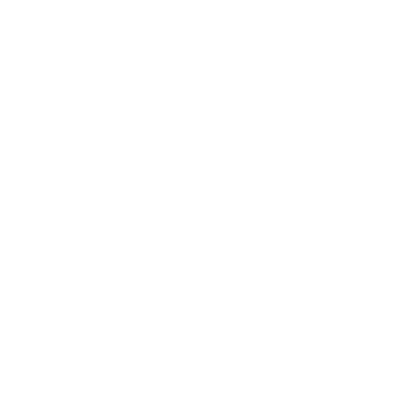

Training:   5%|▌         | 254/5000 [00:08<02:40, 29.65it/s, loss=nan]

In [ ]:

#! with some help  

npl = 128
depth = 3
true_net = NGP_SDF(in_features=2).to(device)

lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.0108],
        [0.0114],
        [0.0094],
        ...,
        [0.0095],
        [0.0098],
        [0.0108]], device='cuda:0', grad_fn=<AddmmBackward0>)


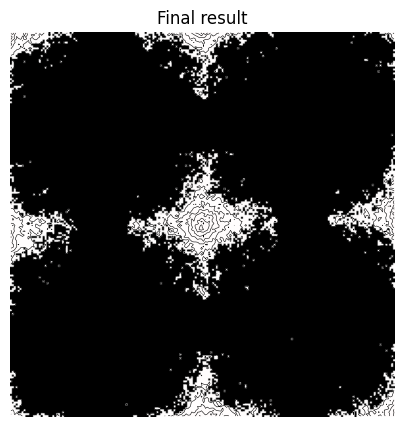

: 

: 

: 

: 

In [ ]:
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

In [17]:
pc2=pc0+0.5
pc2

tensor([[0.0318, 0.3246],
        [0.3430, 0.0253],
        [0.9963, 0.5607],
        ...,
        [0.0883, 0.7838],
        [0.9862, 0.6165],
        [0.4453, 0.9970]], device='cuda:0')

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


lambda_emd is null
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0812],
        [-0.0812],
        [-0.0812],
        ...,
        [-0.0812],
        [-0.0812],
        [-0.0812]], device='cuda:0', grad_fn=<AddmmBackward0>)


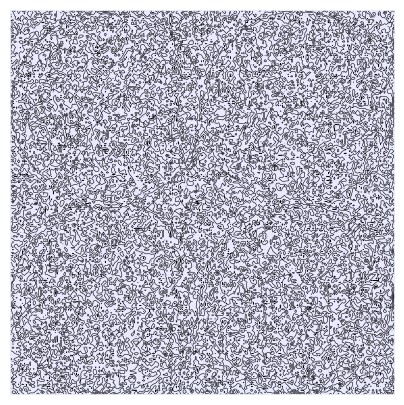

Training:  84%|████████▍ | 4213/5000 [01:30<00:14, 52.80it/s, loss=0.00567]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0062],
        [-0.0060],
        [-0.0069],
        ...,
        [-0.0067],
        [-0.0062],
        [-0.0055]], device='cuda:0', grad_fn=<AddmmBackward0>)


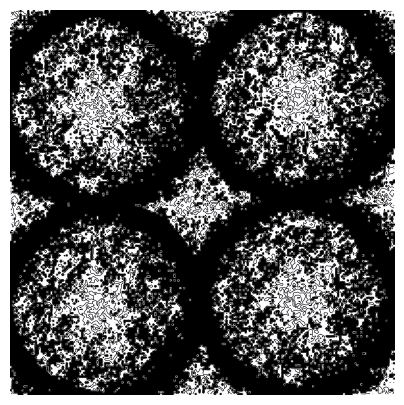

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0066],
        [-0.0072],
        [-0.0079],
        ...,
        [-0.0065],
        [-0.0062],
        [-0.0057]], device='cuda:0', grad_fn=<AddmmBackward0>)


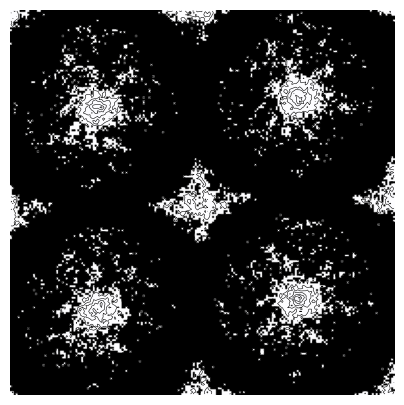

Training: 100%|██████████| 5000/5000 [01:33<00:00, 53.46it/s, loss=0.00575]


Optimizing NN took 93.54 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0067],
        [-0.0072],
        [-0.0076],
        ...,
        [-0.0063],
        [-0.0061],
        [-0.0056]], device='cuda:0', grad_fn=<AddmmBackward0>)


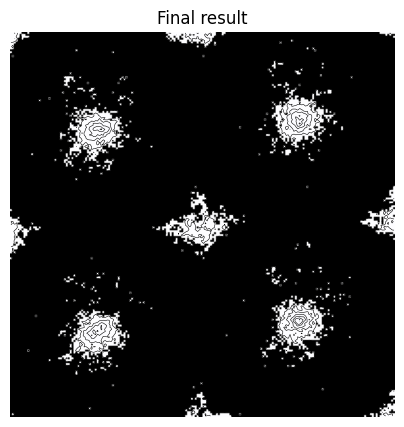

In [29]:

#! with some help  

npl = 128
depth = 3
true_net = NGP_SDF(in_features=2).to(device)

lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc2.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

# Check the pytorch one 

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null


Training:   0%|          | 1/5000 [00:01<1:24:04,  1.01s/it, loss=0.401]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.0618],
        [0.0618],
        [0.0618],
        ...,
        [0.0618],
        [0.0618],
        [0.0618]], device='cuda:0', grad_fn=<AddmmBackward0>)


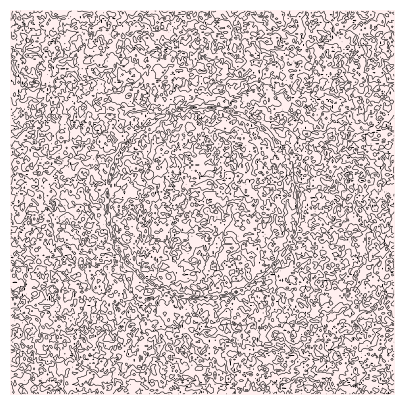

Training:  40%|███▉      | 1999/5000 [00:23<00:33, 88.64it/s, loss=0.00355]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.0051],
        [0.0057],
        [0.0047],
        ...,
        [0.0059],
        [0.0060],
        [0.0060]], device='cuda:0', grad_fn=<AddmmBackward0>)


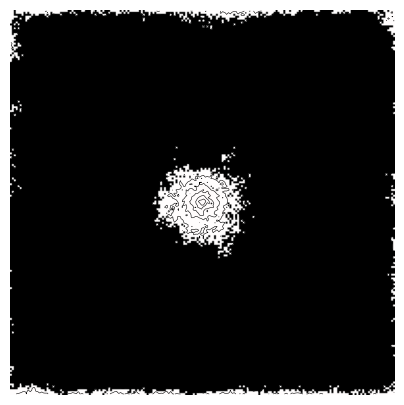

Training:  80%|████████  | 4001/5000 [00:46<00:11, 88.32it/s, loss=0.0036] 

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.0175],
        [0.0183],
        [0.0177],
        ...,
        [0.0193],
        [0.0197],
        [0.0196]], device='cuda:0', grad_fn=<AddmmBackward0>)


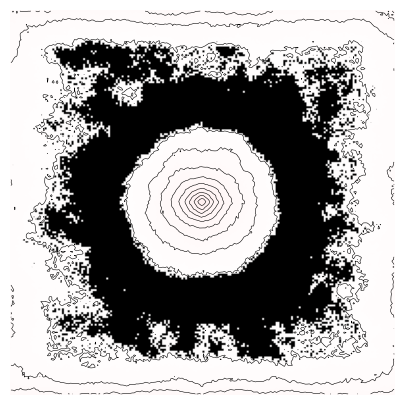

Training: 100%|██████████| 5000/5000 [00:57<00:00, 86.59it/s, loss=0.0015] 


Optimizing NN took 57.74 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.5729],
        [0.5734],
        [0.5713],
        ...,
        [0.6048],
        [0.6112],
        [0.6138]], device='cuda:0', grad_fn=<AddmmBackward0>)


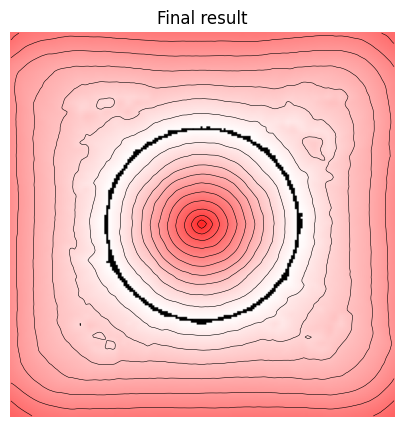

In [18]:

#! with some help  

npl = 128
depth = 3
true_net = SDFNetwork2().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

keys gc [0.34288060665130615, 0.3335734009742737, 0.3332844376564026, 0.3392546474933624, 0.32795754075050354, 0.33477169275283813, 0.3243408799171448, 0.3308670222759247, 0.3283884525299072, 0.33313778042793274, 0.3314642906188965, 0.3295436501502991, 0.32795771956443787, 0.3297407031059265, 0.3337227702140808, 0.33992627263069153, 0.33705538511276245, 0.3337705731391907, 0.3293452858924866, 0.3263486921787262, 0.3367282450199127, 0.3312423825263977, 0.3293437063694, 0.33008021116256714, 0.32730478048324585, 0.32453107833862305, 0.33123859763145447, 0.32726556062698364, 0.32940101623535156, 0.32115939259529114, 0.32251083850860596, 0.3312647044658661, 0.33698856830596924, 0.32648611068725586, 0.33413270115852356, 0.3314090073108673, 0.31990429759025574, 0.3354484438896179, 0.32613423466682434, 0.3310004472732544, 0.3267119824886322, 0.3318878412246704, 0.333577036857605, 0.323038786649704, 0.32556867599487305, 0.31691280007362366, 0.3305312395095825, 0.3323315680027008, 0.333740919828

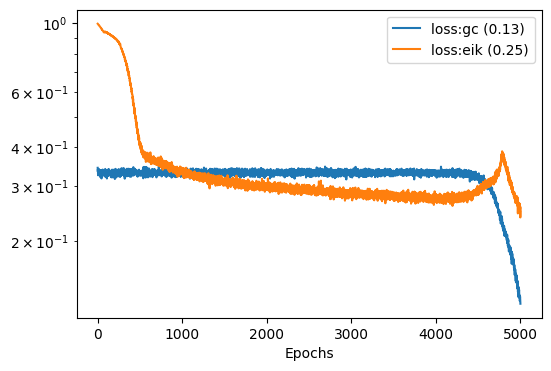

In [28]:


display_loss(list_loss,["pc"])
    

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/10000 [00:00<?, ?it/s, loss=0.0108]

lambda_emd is null
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.0067],
        [0.0067],
        [0.0067],
        ...,
        [0.0067],
        [0.0067],
        [0.0067]], device='cuda:0', grad_fn=<AddmmBackward0>)


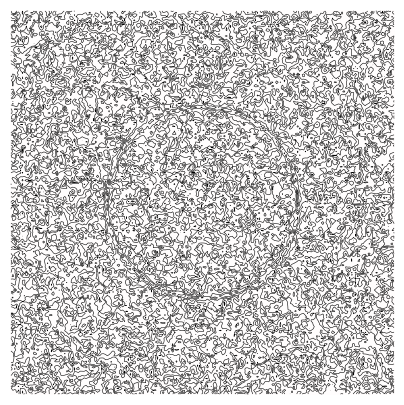

Training:  20%|██        | 2000/10000 [00:22<01:30, 88.39it/s, loss=0.00355]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[8.6940e-04],
        [4.0277e-04],
        [3.5087e-05],
        ...,
        [4.3994e-04],
        [6.8795e-04],
        [4.5719e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


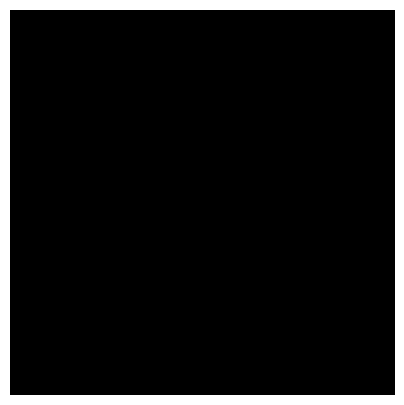

Training:  40%|███▉      | 3999/10000 [00:45<01:06, 89.75it/s, loss=0.00363]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 5.9410e-04],
        [ 7.7721e-05],
        [-5.0645e-05],
        ...,
        [-8.4285e-06],
        [ 6.4618e-04],
        [ 2.7706e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


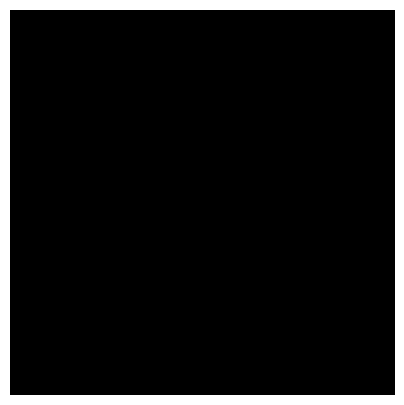

Training:  60%|█████▉    | 5999/10000 [01:08<00:44, 89.49it/s, loss=0.00357]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 5.0429e-04],
        [-2.4510e-05],
        [-1.8989e-05],
        ...,
        [-2.8342e-04],
        [ 4.9637e-04],
        [ 1.8465e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


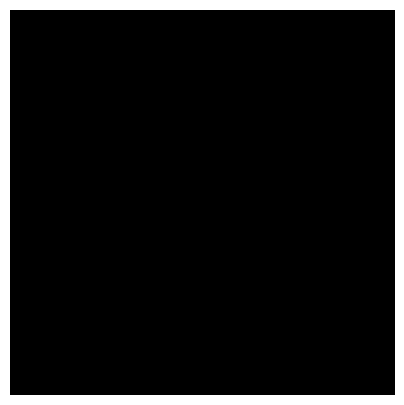

Training:  80%|███████▉  | 7999/10000 [01:30<00:22, 87.01it/s, loss=0.00352]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 3.1087e-04],
        [-1.3237e-04],
        [-4.2362e-05],
        ...,
        [-3.5444e-04],
        [ 2.5756e-04],
        [ 3.6997e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


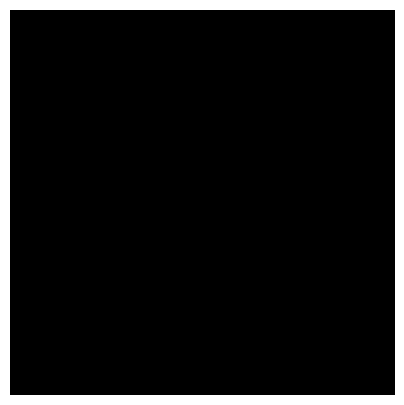

Training: 100%|██████████| 10000/10000 [01:53<00:00, 88.05it/s, loss=0.00352]


Optimizing NN took 113.57 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 3.9091e-04],
        [-1.8285e-04],
        [ 2.7371e-05],
        ...,
        [-2.0670e-04],
        [ 4.2082e-04],
        [ 5.1373e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


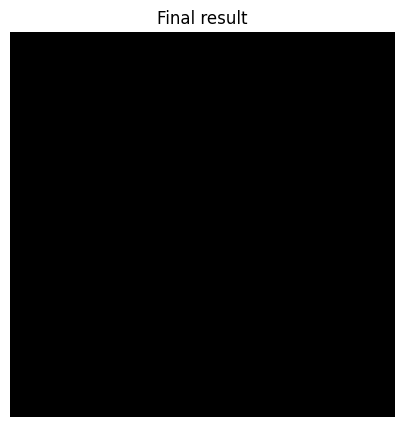

keys gc [0.3307904303073883, 0.3242326080799103, 0.33130431175231934, 0.3308052718639374, 0.32407084107398987, 0.3310750424861908, 0.3357720673084259, 0.33394569158554077, 0.3340652585029602, 0.3300594091415405, 0.3301752507686615, 0.3261953294277191, 0.3348022997379303, 0.3336810767650604, 0.3241178095340729, 0.33291006088256836, 0.32912176847457886, 0.3331846296787262, 0.3381376266479492, 0.3339492678642273, 0.3340778946876526, 0.3343563377857208, 0.3328295350074768, 0.327077180147171, 0.3326737880706787, 0.334803968667984, 0.33087360858917236, 0.32719889283180237, 0.3427542746067047, 0.32577964663505554, 0.334415078163147, 0.32703089714050293, 0.3297125995159149, 0.3331463038921356, 0.3279438614845276, 0.33236220479011536, 0.3245842456817627, 0.3286443054676056, 0.32922670245170593, 0.3241877555847168, 0.3336819112300873, 0.3303338885307312, 0.33466243743896484, 0.33248382806777954, 0.32727763056755066, 0.34184566140174866, 0.3357747495174408, 0.33455032110214233, 0.3262879550457001

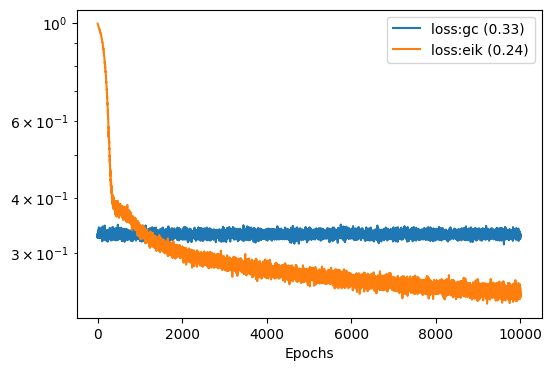

In [29]:

#! with some help  

npl = 128
depth = 3
true_net = SDFNetwork2().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 3.9091e-04],
        [-1.8285e-04],
        [ 2.7371e-05],
        ...,
        [-2.0670e-04],
        [ 4.2082e-04],
        [ 5.1373e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


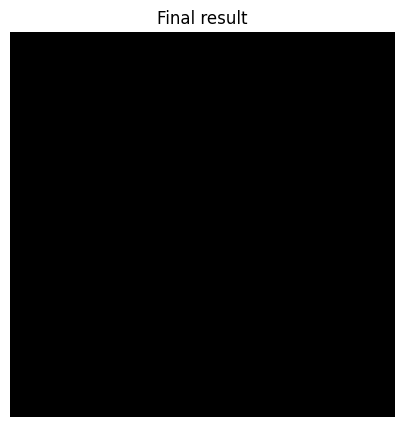

In [30]:
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

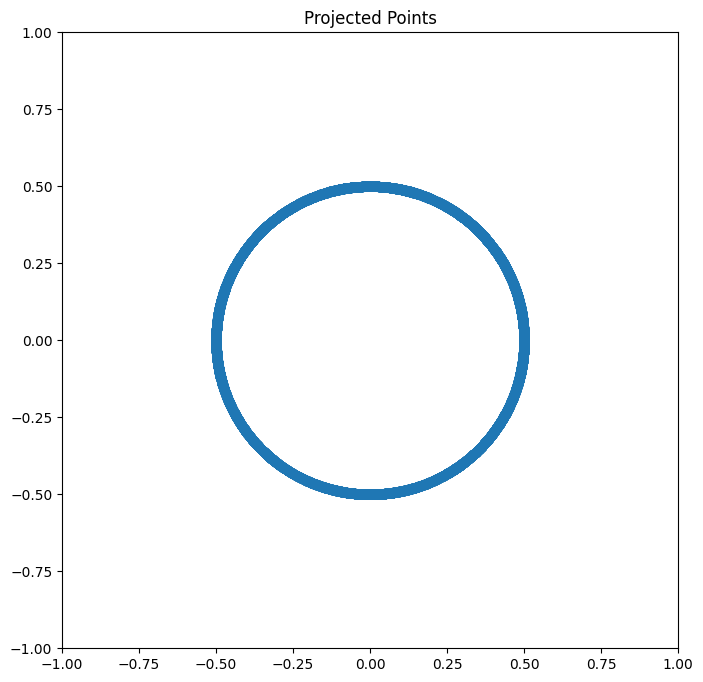

In [34]:
import torch
import matplotlib.pyplot as plt
from src.loss.utils import gradient
from src.results.display import display_projection

pc_t0 = pc0.clone().to(device)
pc_t0.requires_grad = True
display_projection(true_net,pc_t0)


In [38]:
from src.loss import * 
dim_space=2 
net=true_net
batch_size=2000
pts_random = sample_xt(batch_size, dim_space)
pts_random.requires_grad = True

sdf_random = net(pts_random)

grad_tot_random = gradient(sdf_random, pts_random)
grad_spatial = grad_tot_random[:, 0:2]

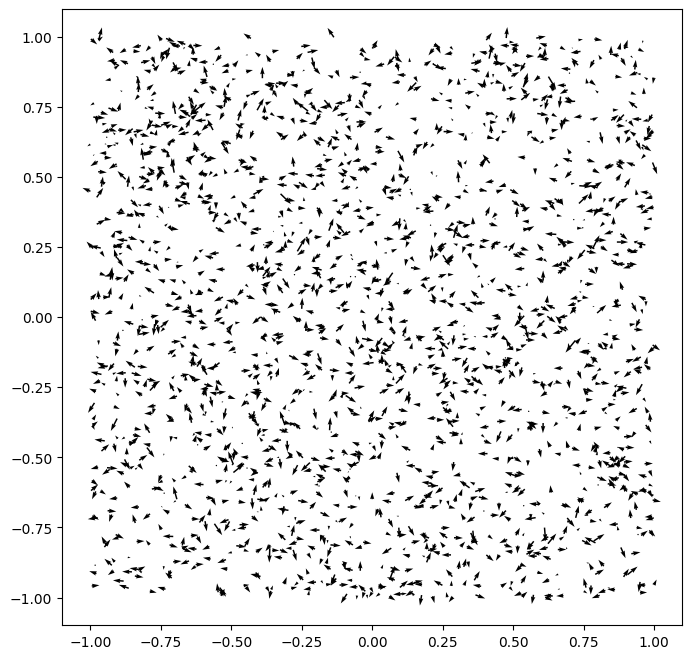

In [44]:
grad_spatial
# display the gradient
plt.figure(figsize=(8, 8))
plt.quiver(pts_random[:, 0].detach().cpu().numpy(), pts_random[:, 1].detach().cpu().numpy(), grad_spatial[:, 0].detach().cpu().numpy(), grad_spatial[:, 1].detach().cpu().numpy())
plt.show()


coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[ 3.9091e-04],
        [-1.8285e-04],
        [ 2.7371e-05],
        ...,
        [-2.0670e-04],
        [ 4.2082e-04],
        [ 5.1373e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)


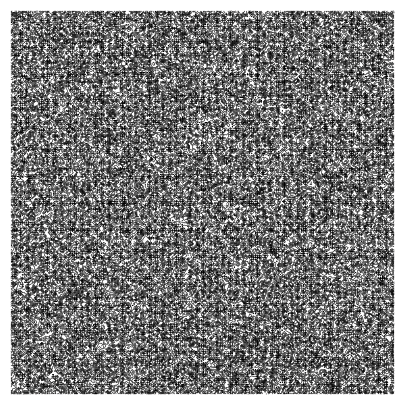

In [49]:
display_result(true_net,200,eps=1e-7)

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/10000 [00:00<?, ?it/s, loss=0.257]

lambda_emd is null
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0492],
        [-0.0492],
        [-0.0492],
        ...,
        [-0.0492],
        [-0.0492],
        [-0.0492]], device='cuda:0', grad_fn=<AddmmBackward0>)


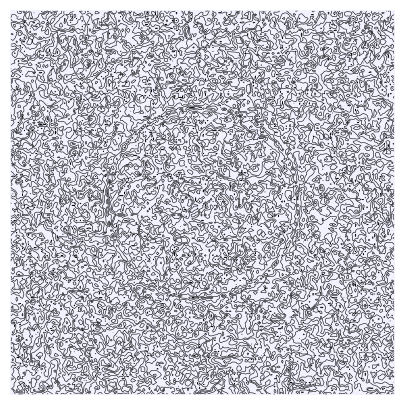

Training:  20%|█▉        | 1999/10000 [00:22<01:31, 87.75it/s, loss=0.00358]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0041],
        [-0.0037],
        [-0.0044],
        ...,
        [-0.0058],
        [-0.0051],
        [-0.0052]], device='cuda:0', grad_fn=<AddmmBackward0>)


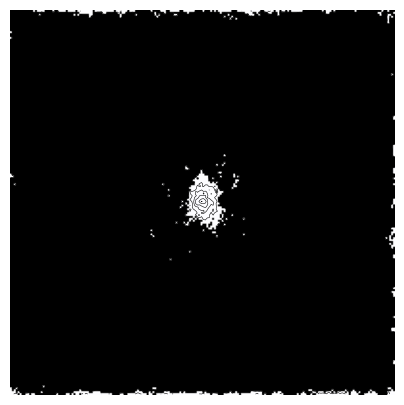

Training:  40%|████      | 4000/10000 [00:45<01:07, 89.50it/s, loss=0.00358]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0060],
        [-0.0059],
        [-0.0065],
        ...,
        [-0.0087],
        [-0.0080],
        [-0.0081]], device='cuda:0', grad_fn=<AddmmBackward0>)


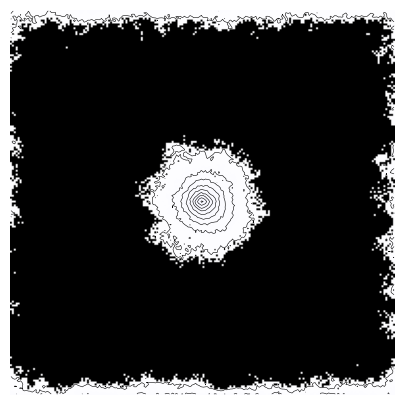

Training:  60%|█████▉    | 5999/10000 [01:08<00:45, 88.69it/s, loss=0.000123]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.8845],
        [-0.8826],
        [-0.8806],
        ...,
        [-0.9039],
        [-0.9112],
        [-0.9125]], device='cuda:0', grad_fn=<AddmmBackward0>)


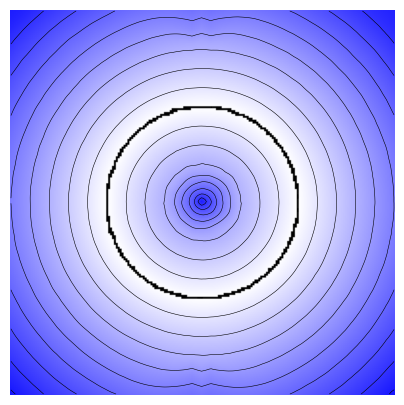

Training:  80%|███████▉  | 7999/10000 [01:30<00:22, 89.64it/s, loss=2.78e-5] 

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.9151],
        [-0.9080],
        [-0.9010],
        ...,
        [-0.9003],
        [-0.9070],
        [-0.9138]], device='cuda:0', grad_fn=<AddmmBackward0>)


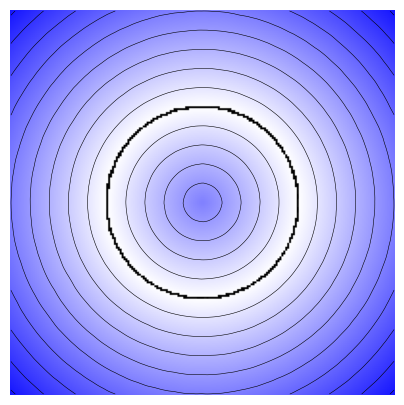

Training: 100%|██████████| 10000/10000 [01:53<00:00, 88.32it/s, loss=2.36e-5]


Optimizing NN took 113.22 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.9149],
        [-0.9083],
        [-0.9016],
        ...,
        [-0.9018],
        [-0.9086],
        [-0.9155]], device='cuda:0', grad_fn=<AddmmBackward0>)


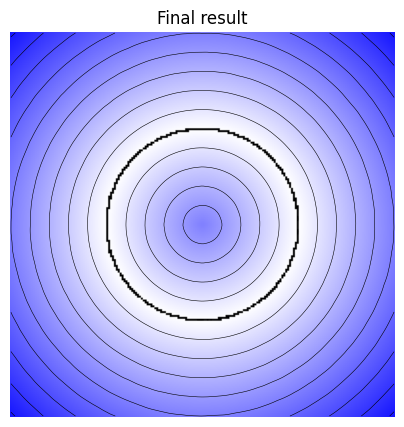

keys gc [0.3335978388786316, 0.33077967166900635, 0.3304435908794403, 0.33651942014694214, 0.3371869623661041, 0.32795190811157227, 0.3308374583721161, 0.33120813965797424, 0.32974153757095337, 0.3270612955093384, 0.33198127150535583, 0.3424369692802429, 0.3281305730342865, 0.3353501558303833, 0.3335205912590027, 0.33442896604537964, 0.3328356444835663, 0.32489991188049316, 0.32919764518737793, 0.3336906433105469, 0.32970473170280457, 0.3338880240917206, 0.33339157700538635, 0.3306484520435333, 0.3255939185619354, 0.3429923355579376, 0.3303542137145996, 0.3338305950164795, 0.3328060507774353, 0.34013503789901733, 0.33159875869750977, 0.3332020938396454, 0.3321892321109772, 0.32846078276634216, 0.3343898355960846, 0.3338472545146942, 0.33724793791770935, 0.33356228470802307, 0.3370271623134613, 0.32932955026626587, 0.33015021681785583, 0.3319742679595947, 0.3299010694026947, 0.33286166191101074, 0.3268980383872986, 0.3319903016090393, 0.33134377002716064, 0.3240613043308258, 0.331419199

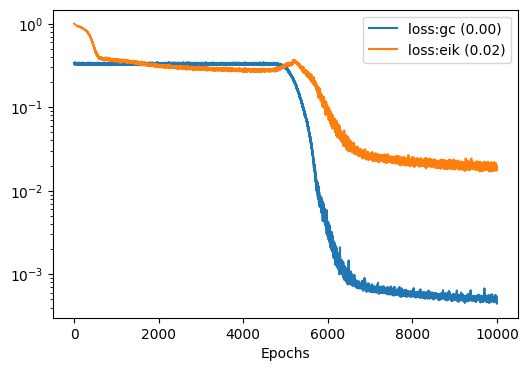

In [50]:

#! with some help  

npl = 128
depth = 3
true_net = SDFNetwork2().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])

In [13]:
import commentjson as json
import tinycudann as tcnn
import torch

In [50]:
true_net = SDFNetwork2().to(device)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
output=true_net(pc_t0)
output

initialisation Xavier True fix_init False


tensor([[-0.0399],
        [-0.0399],
        [-0.0399],
        ...,
        [-0.0399],
        [-0.0399],
        [-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)

starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=1


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

lambda_pc is null
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-1/2*(d*Sum((a-b)**2)),1] with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,1,1), d=Var(3,1,2) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -(((a-b)*(d*Extract(e,1,1)))*Exp((c-1/2*(d*Sum((a-b)**2)))-Extract(f,0,1))) with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,1,1), d=Var(3,1,2), e=Var(4,2,0), f=Var(5,2,0) ... OK


Training:   0%|          | 1/10000 [00:00<1:11:26,  2.33it/s, loss=0.00795]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.1315],
        [0.1315],
        [0.1316],
        ...,
        [0.1316],
        [0.1316],
        [0.1316]], device='cuda:0', grad_fn=<AddmmBackward0>)


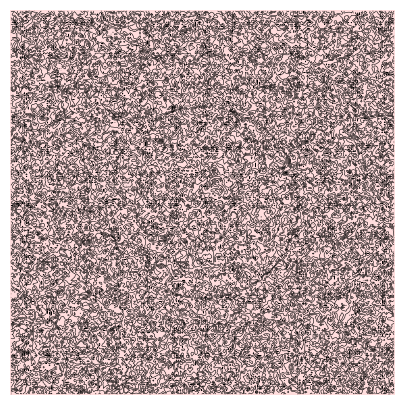

Training:  20%|██        | 2000/10000 [01:58<07:49, 17.06it/s, loss=5.43e-5] 

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.9189],
        [0.9130],
        [0.9066],
        ...,
        [0.9048],
        [0.9125],
        [0.9193]], device='cuda:0', grad_fn=<AddmmBackward0>)


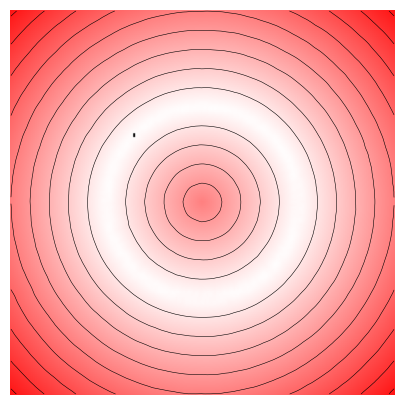

Training:  40%|████      | 4000/10000 [03:56<06:19, 15.81it/s, loss=3.71e-5]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.9178],
        [0.9104],
        [0.9034],
        ...,
        [0.9024],
        [0.9104],
        [0.9175]], device='cuda:0', grad_fn=<AddmmBackward0>)


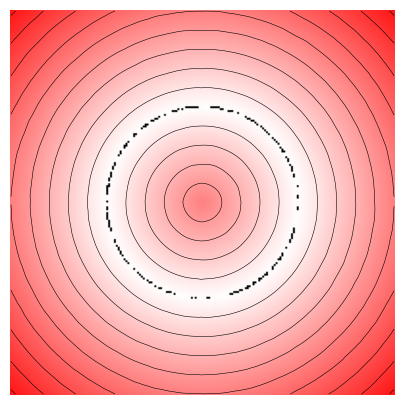

Training:  60%|██████    | 6000/10000 [05:59<04:08, 16.08it/s, loss=2.9e-5] 

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.9142],
        [0.9075],
        [0.9006],
        ...,
        [0.9020],
        [0.9090],
        [0.9158]], device='cuda:0', grad_fn=<AddmmBackward0>)


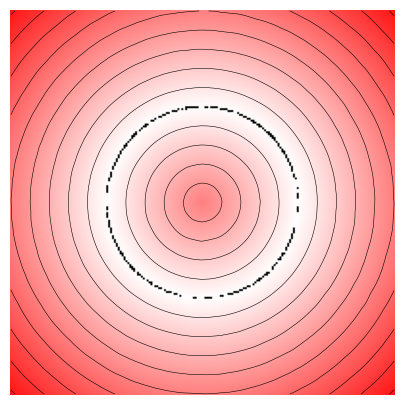

Training:  80%|████████  | 8000/10000 [08:02<02:01, 16.49it/s, loss=2.79e-5]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.9142],
        [0.9075],
        [0.9005],
        ...,
        [0.9018],
        [0.9087],
        [0.9157]], device='cuda:0', grad_fn=<AddmmBackward0>)


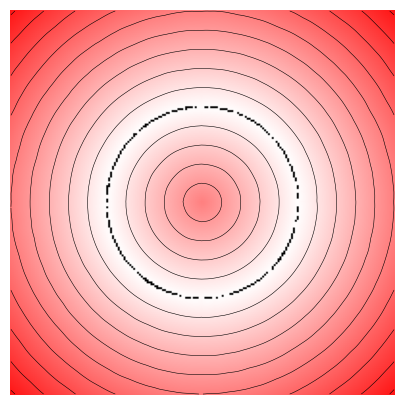

Training: 100%|██████████| 10000/10000 [10:05<00:00, 16.51it/s, loss=2.7e-5]


Optimizing NN took 605.75 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[0.9155],
        [0.9079],
        [0.9006],
        ...,
        [0.8998],
        [0.9070],
        [0.9141]], device='cuda:0', grad_fn=<AddmmBackward0>)


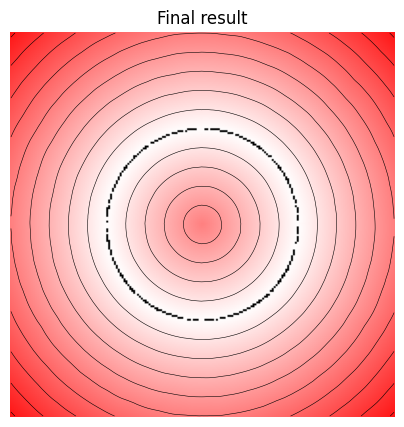

keys emd [0.003681072499603033, 0.004141516517847776, 0.0031451694667339325, 0.0024736407212913036, 0.0020104669965803623, 0.0016792835667729378, 0.0014257251750677824, 0.0012278915382921696, 0.001067599281668663, 0.0009360727854073048, 0.0008273730054497719, 0.000734908040612936, 0.0006540738977491856, 0.000583951361477375, 0.0005231286631897092, 0.0004687816835939884, 0.00042179878801107407, 0.0003811524948105216, 0.0003455010009929538, 0.0003141904016956687, 0.0002865336136892438, 0.00026198418345302343, 0.000240225694142282, 0.0002209763042628765, 0.0002039899700321257, 0.0001889091799966991, 0.00017539877444505692, 0.00016328960191458464, 0.00015245832037180662, 0.00014264672063291073, 0.00013377470895648003, 0.0001257635885849595, 0.00011839932994917035, 0.00011165672913193703, 0.00010564702097326517, 0.00010000058682635427, 9.481812594458461e-05, 9.008776396512985e-05, 8.57118284329772e-05, 8.157838601619005e-05, 7.76731176301837e-05, 7.409940008074045e-05, 7.082876982167363e-05

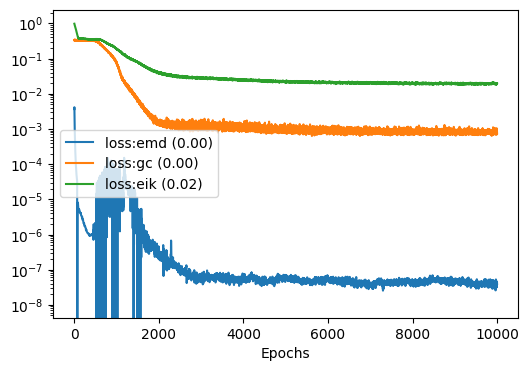

In [40]:

#! with some help  

npl = 128
depth = 3
true_net = SDFNetwork2().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=10000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])

initialisation Xavier True fix_init False
starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=1


Training:   0%|          | 0/10000 [00:00<?, ?it/s, loss=0.00451]

lambda_pc is null
coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.0456],
        [-0.0456],
        [-0.0455],
        ...,
        [-0.0456],
        [-0.0456],
        [-0.0456]], device='cuda:0', grad_fn=<AddmmBackward0>)


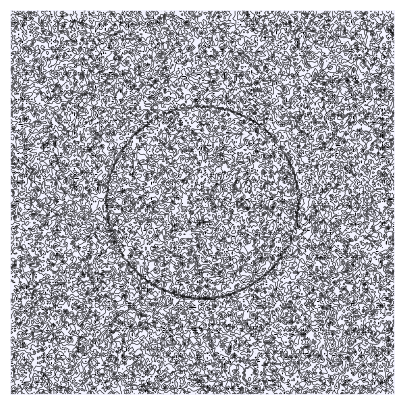

Training:  20%|██        | 2000/10000 [01:12<04:43, 28.17it/s, loss=0.000133]

coords shape before adding t: torch.Size([40000, 2])
the sdf tensor([[-0.9066],
        [-0.9029],
        [-0.9001],
        ...,
        [-0.9122],
        [-0.9223],
        [-0.9285]], device='cuda:0', grad_fn=<AddmmBackward0>)


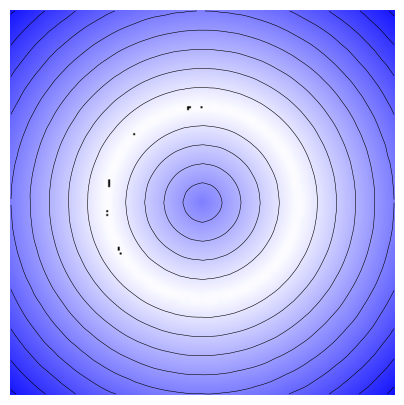

Training:  22%|██▏       | 2171/10000 [01:19<04:41, 27.80it/s, loss=0.00018] 

KeyboardInterrupt: 

Training:  22%|██▏       | 2171/10000 [01:30<04:41, 27.80it/s, loss=0.00018]

In [ ]:

#! with some help  
from src.models.tiny_cu import SDF_TCNN  
npl = 128
depth = 3
true_net = SDF_TCNN().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])

## Different noise now !

In [ ]:

#! with some help  


true_net = SDFNetwork2().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=10000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])